In [1]:
import sys
print('iPython Kernel -->', sys.argv)
print('Environment -->', sys.prefix)

iPython Kernel --> ['C:\\anaconda3\\envs\\ling\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Babak Ravandi\\AppData\\Roaming\\jupyter\\runtime\\kernel-6d6b8471-2c63-484d-ac05-cefc0a776e95.json']
Environment --> C:\anaconda3\envs\ling


In [3]:
import pandas as pd
import numpy as np
import json
from collections import OrderedDict 

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import random

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns

import networkx as nx
import GraphHierarchy as gh

from tqdm import tqdm

from scipy import stats

import gspread

'''
This layout algorithm requires installin graphviz
https://pygraphviz.github.io/documentation/stable/install.html
'''
from networkx.drawing.nx_agraph import graphviz_layout

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth', 0)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

%matplotlib inline

In [4]:
import os
from pandas import ExcelWriter


def save_xls(dfs_dict, xls_path, open=False):
    if type(dfs_dict) is not dict:
        dfs_dict = {'sheet1': dfs_dict}
    
    with ExcelWriter(xls_path) as writer:
        for df_name, df in dfs_dict.items():
            df.to_excel(writer, df_name)
        writer.save()

    if open is True:
        os.system('start EXCEL.EXE "{}"'.format(os.path.abspath(xls_path)))
    pass

# Load Networks

In [56]:
centuries = {
    '11': 11.0, '12': 12.0, '13': 13.0, '14E': 14.1, '14L': 14.2, '15': 15.0, '16': 16.0, '17': 17.0
}

## Check Mistake Duplicate Edges & Add Frequency

THe only exception of having multiple interactions between a source and target is in 17th century as below. ALl other centuries must have only a single interaction (type of edge) between two nodes.

Source:'PR ze'	 |	Target: 'IV werden'   |   Interactions: {PP, VP}

In [6]:
gc = gspread.service_account(filename='google_service_credentials.json')

In [14]:
google_sheet_ID = '1CWbPlXrKa41DL02mO6pny8BC4Hd7xwbIhA3-ZthyjWc'

german_dataset_gsheet = gc.open_by_key(google_sheet_ID)

german_dataset_gsheet.worksheets()

[<Worksheet '11' id:2063048793>,
 <Worksheet '12' id:936686375>,
 <Worksheet '13' id:698480864>,
 <Worksheet '14E' id:1758104757>,
 <Worksheet '14L' id:1538902914>,
 <Worksheet '15' id:2099895106>,
 <Worksheet '16' id:121866148>,
 <Worksheet '17' id:1360439213>]

In [33]:
cent_interaction_validate = {}
cent_raw_df = {}
cent_df_dict = {}

for cent in centuries.keys():

    print('------------ Cent:', cent)
    
    cent_df = pd.DataFrame(german_dataset_gsheet.worksheet(cent).get_all_records())

    cent_df.loc[:, ['Source', 'Target', 'Interaction']] = (
        cent_df.loc[:, ['Source', 'Target', 'Interaction']].apply(lambda x: x.str.strip(), axis=1)
    ) 

    cent_raw_df[cent] = cent_df.copy()
    
    """"""
    G=nx.from_pandas_edgelist(
        cent_df, source='Source', target='Target', 
        edge_attr=True, create_using=nx.DiGraph()
    )
    
    # nx.draw(G, with_labels=True)
    # print(type(G))
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    print('num edges in dataset:', len(cent_df), ' num network edges:', G.number_of_edges())
    """"""

    cent_df['frequency'] = cent_df['Interaction']

    cent_df = (
        cent_df.groupby(['Source', 'Target'])
        .agg({
            'Interaction': lambda x: set([v.upper() for v in x]),
            'frequency': np.size,
         })
        .reset_index()
    )

    cent_df['Interaction count'] = cent_df['Interaction'].apply(len)

    # print(path_net)
    cent_df = cent_df.sort_values(by=['Interaction count', 'frequency'], ascending=False)

    cent_df_dict[cent] = cent_df
    
    cent_interaction_validate[cent] = cent_df[cent_df['Interaction count'] > 1]  
    
    print(
        'Interaction count > 1 -->', len(cent_interaction_validate[cent])
    )
    
    del cent_df
    pass
# cent_df_dict.keys()

------------ Cent: 11
num edges in excel: 971  num network edges: 731
Interaction count > 1 --> 0
------------ Cent: 12
num edges in excel: 1194  num network edges: 819
Interaction count > 1 --> 0
------------ Cent: 13
num edges in excel: 2504  num network edges: 1364
Interaction count > 1 --> 1
------------ Cent: 14E
num edges in excel: 2327  num network edges: 1354
Interaction count > 1 --> 0
------------ Cent: 14L
num edges in excel: 2518  num network edges: 1603
Interaction count > 1 --> 0
------------ Cent: 15
num edges in excel: 2228  num network edges: 1426
Interaction count > 1 --> 0
------------ Cent: 16
num edges in excel: 3363  num network edges: 2461
Interaction count > 1 --> 0
------------ Cent: 17
num edges in excel: 3938  num network edges: 3122
Interaction count > 1 --> 1


In [57]:
print('WE MUST HAVE Only two nodes with multiple edges!')
cent_interaction_validate['17']

WE MUST HAVE Only two nodes with multiple edges!


,Source,Target,Interaction,frequency,Interaction count
379,AX werden,PP/S er,"{PP, VP}",91,2


## Tree Specs and Validation

In [35]:
# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [36]:
def lenght_all_pairs_shortest_path(G_nx):
    q = nx.all_pairs_shortest_path(G_nx)
    
    p_all = []

    for p in q:
        p_all.append(p)

    p_lenght = []
    path_df = []
    
    for p_2 in [p[1].values() for p in p_all]:
        for p3 in p_2:
            p_lenght.append(len(p3))
            
            path_df.append({'l': len(p3), 'p': p3})
#         p_lenght += [len(p3) for p3 in p_2]

        pass
    
    path_df = pd.DataFrame(path_df)
    path_df['p'] = path_df['p'].astype('str')
    
    return path_df

In [142]:
tree_cent_df = []
G_list = {}
G_not_tree_list = {}
root_codes = [1, -1, -2] # tree, '', cycle (why cycle valentina?)

for cent in centuries.keys():
    print('------------------', cent, '------------------')
    
    sentence_started = False
    G = None
    row_num = 0
    root_row_num_current = None

    tree_root = None
    is_root_code = None

    G_list[cent] = []
    G_not_tree_list[cent] = []

    for source, target, is_root in cent_raw_df[cent][['Source', 'Target', 'Root']].to_numpy():
        if (sentence_started is True and is_root in root_codes) or (row_num == len(cent_raw_df[cent]) - 1):
            
            # in case no root is marked
            if G is None:
                row_num += 1
                continue
            
    #         is_root_code = is_root
            sentence_started = False

            if(nx.is_tree(G)):
                pos = hierarchy_pos(G, root=tree_root)

                path_df = lenght_all_pairs_shortest_path(G)

                G_list[cent].append({
                    'cent': cent,
                    'root':tree_root, 
                    'is_root': is_root_code,
                    'G': G,
                    'tree height from diamter directed': path_df['l'].max(),
                    'diameter indirected': nx.diameter(G.to_undirected()),
                    'tree height from positions': len(set([v[1] for v in pos.values()]))
                })

            else:
                G_not_tree_list[cent].append((root_row_num_current, is_root_code, G))
    #             print('not tree')
                pass
            pass

        #if is_root == 1:
        if is_root in root_codes:
            is_root_code = is_root
            sentence_started = True
            root_row_num_current = row_num
            tree_root = source
            G = nx.DiGraph()
            pass
        
        # in case no root is marked
        if G is not None:
            G.add_edge(source, target)

        row_num += 1
        pass

    del is_root, is_root_code
    print('Num Trees:', len(G_list), 'Num NOT trees:', len(G_not_tree_list))
    
    cent_tree_specs_df = pd.DataFrame(G_list[cent])
    
    if 'is_root' in cent_tree_specs_df:
        print('root code freq:\n', cent_tree_specs_df['is_root'].fillna('NA').value_counts())
    
    tree_cent_df.append(cent_tree_specs_df)
    pass

tree_cent_df = pd.concat(tree_cent_df).reset_index(drop=True)


------------------ 11 ------------------
Num Trees: 1 Num NOT trees: 1
root code freq:
  1    232
-2    1  
Name: is_root, dtype: int64
------------------ 12 ------------------
Num Trees: 2 Num NOT trees: 2
root code freq:
 1    296
Name: is_root, dtype: int64
------------------ 13 ------------------
Num Trees: 3 Num NOT trees: 3
root code freq:
 1    681
Name: is_root, dtype: int64
------------------ 14E ------------------
Num Trees: 4 Num NOT trees: 4
root code freq:
  1    579
-2    1  
Name: is_root, dtype: int64
------------------ 14L ------------------
Num Trees: 5 Num NOT trees: 5
------------------ 15 ------------------
Num Trees: 6 Num NOT trees: 6
------------------ 16 ------------------
Num Trees: 7 Num NOT trees: 7
root code freq:
  1    545
-1    18 
Name: is_root, dtype: int64
------------------ 17 ------------------
Num Trees: 8 Num NOT trees: 8
root code freq:
  1    579
-1    76 
-2    4  
Name: is_root, dtype: int64


In [143]:
tree_cent_df

,cent,root,is_root,G,tree height from diamter directed,diameter indirected,tree height from positions
0,11,AX werden,1,"(AX werden, PcPs pflanzen, DM/S der, PR zu, N/O jerusalem)",4,4,4
1,11,AX werden,1,"(AX werden, PcPs beswichen, PP/S ich, PK niht, PR mit, N/O doctrina, AJ/O perversus)",5,5,5
2,11,V werden,1,"(V werden, AD so, N/S auditor, AJ/S din)",3,3,3
3,11,AX sin,1,"(AX sin, PcPs werden, PP/S ich, AJ/S edel, PR von, N/O cyprus)",4,3,4
4,11,AX werden,1,"(AX werden, PcPs geantvristen)",2,1,2
...,...,...,...,...,...,...,...
3007,17,MV sollen,1,"(MV sollen, IV werden, N/S herz, AJ/S unser)",3,3,3
3008,17,MV sollen,1,"(MV sollen, IV werden, N/S herz, AJ/S unser)",3,3,3
3009,17,PcPs werden,-1,"(PcPs werden, PcPs verspüren, PR ze, N/O drei, AJ/O göttlich, AJ/O dise)",5,4,5
3010,17,AX werden,1,"(AX werden, PcPs schicken, N/S graf, N/S scabricus, CJ als, N/S gesandter, AR/S ein, PR aus, N/O polen)",5,6,5


### Export Not Trees

In [109]:
cent = '11'
print('Number of NOT tree items for cent', cent, ':')
pd.DataFrame(G_not_tree_list[cent], columns=['row number', 'root code', 'tree nx'])['root code'].value_counts()

Number of NOT tree items for cent 11 :


-2    5
Name: root code, dtype: int64

In [110]:
'''
Export Not trees
'''

G_not_tree_list[cent] = sorted(G_not_tree_list[cent], key=lambda x: x[1], reverse=True)

limit_number_nets = 30
not_tree_df = []
num_not_tree = len(G_not_tree_list)
figs = []
ax_index = 0

for i, not_tree in tqdm(enumerate(G_not_tree_list[cent])):
    if i % limit_number_nets == 0:
        plt.close()
        
        fig, axs = plt.subplots(limit_number_nets, figsize=(10, limit_number_nets * 4), dpi=200)
        ax_index = 0
        
        figs.append(fig)
        pass

    not_tree_df.append({'row_num': row_num + 2, 'cent': cent})
    
    row_num, is_root_code, G = not_tree   

    pos=graphviz_layout(G, prog=['dot', 'twopi', 'sfdp', 'circo'][0])

    nx.draw(G, pos=pos, with_labels = True, ax=axs[ax_index])
    axs[ax_index].set_title(
        '--------------------------------------Row Number: {} | code: {} ({} from {})--------------------------------------'.format(
        row_num + 2,
        is_root_code,
        i + 1,
        num_not_tree
    ))
    
    ax_index += 1
    pass

plt.close()

not_tree_df = pd.DataFrame(not_tree_df)
not_tree_df.to_excel(path_dataset_dir + 'not_tree/cent_{}.xlsx'.format(cent))

for i, fig in enumerate(figs):
    path_fig = path_dataset_dir + 'not_tree/cent_{}_part_{}.png'.format(cent, i)
    fig.savefig(path_fig, bbox_inches='tight')
    print('Saved fig at: ', path_fig)
    del fig
    pass

del figs
    
print('Cent:', cent)
# plt.tight_layout()

5it [00:00,  6.01it/s]


Saved fig at:  D:/GoogleDrive/Research/Linguistic project/German/data/legacy/not_tree/cent_11_part_0.png
Cent: 11


Cent: 11
Tree height: 4


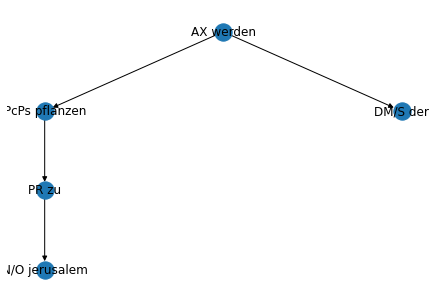

In [113]:
'''
Visualize a Tree
'''
# https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx
# from networkx.drawing.nx_pydot import graphviz_layout
# pos = graphviz_layout(giant, prog="circo")

# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
index_tree = [0, 515, 400][0]

tree_root = G_list[cent][index_tree]['root']
G = G_list[cent][index_tree]['G']

pos = hierarchy_pos(G, root=tree_root)

nx.draw(G, pos=pos, with_labels = True)

# nx.draw(giant, pos=nx.spring_layout(giant), with_labels = True)
print('Cent:', cent)
print('Tree height:', len(set([v[1] for v in pos.values()])))

Cent: 11
Tree height: 3 root code: -2


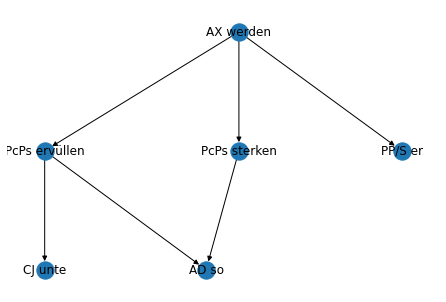

In [115]:
'''
Visualize a bad Tree
'''
# https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx
# from networkx.drawing.nx_pydot import graphviz_layout
# pos = graphviz_layout(giant, prog="circo")

# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
index_tree = [0, 515, 400][0]

row_number, root_code, G = G_not_tree_list[cent][index_tree]

pos=graphviz_layout(G, prog=['dot', 'twopi', 'sfdp', 'circo'][0])

nx.draw(G, pos=pos, with_labels = True)

# nx.draw(giant, pos=nx.spring_layout(giant), with_labels = True)
print('Cent:', cent)
print('Tree height:', len(set([v[1] for v in pos.values()])), 'root code:', root_code)

## Load Corrected Nets with Freq

In [53]:
cent_nets = OrderedDict()
syntactic_nets = []

for cent, cent_df in cent_df_dict.items():
    print('------- cent:', cent)
    
#     cent_df = pd.read_excel( path_dataset_dir + path_net).drop(columns='Unnamed: 0')
    
    cent_df['Source'] = cent_df['Source'].str.lower().apply(lambda x: x.split(' ')[0].upper() + ' ' + ' '.join(x.split(' ')[1:]))
    cent_df['Target'] = cent_df['Target'].str.lower().apply(lambda x: x.split(' ')[0].upper() + ' ' + ' '.join(x.split(' ')[1:]))
    
    cent_df.loc[:, 'Source':'Target'] = cent_df.loc[:, 'Source':'Target'].apply(
        lambda x: x.str.strip())
    
#     print(cent_df.columns)
    G = nx.from_pandas_edgelist(
        cent_df, 
        source='Source', 
        target='Target', 
        edge_attr=True,
#         edge_attr=['Interaction', 'frequency', 'Interaction count'], 
#         Created a directed graph
        create_using=nx.DiGraph()
    )
    
    cent_df['cent'] = cent
    syntactic_nets.append(cent_df)
    
    print('n:', G.number_of_nodes(), 'e:', G.number_of_edges())
    
    cent_nets[cent] = G
    pass

syntactic_nets = pd.concat(syntactic_nets).reset_index(drop=True)
syntactic_nets

------- cent: 11
n: 445 e: 729
------- cent: 12
n: 477 e: 819
------- cent: 13
n: 775 e: 1356
------- cent: 14E
n: 744 e: 1349
------- cent: 14L
n: 759 e: 1603
------- cent: 15
n: 734 e: 1426
------- cent: 16
n: 1194 e: 2461
------- cent: 17
n: 1707 e: 3122


,Source,Target,Interaction,frequency,Interaction count,cent
0,AX werden,PP/S er,{VP},43,1,11
1,AX sin,PCPS werden,{VP},11,1,11
2,V werden,PP/S er,{VP},11,1,11
3,AX werden,PK ne,{VP},9,1,11
4,AX werden,PP/S du,{VP},9,1,11
...,...,...,...,...,...,...
12875,V werden,PR allzu,{VP},1,1,17
12876,V werden,PR bei,{VP},1,1,17
12877,V werden,PR hinfür,{VP},1,1,17
12878,V werden,PR von,{VP},1,1,17


In [54]:
if False:
    path_syntactic_nets = path_dataset_dir + 'syntactic_nets_german.xlsx'
    print(path_syntactic_nets)
    syntactic_nets.to_excel(path_syntactic_nets)
    pass

In [55]:
nodes_all_cent = set(syntactic_nets['Source']).union(set(syntactic_nets['Target']))

[n for n in nodes_all_cent if 'werden' in n]

['AX werden', 'PCPS werden', 'V werden', 'IV werden']

### Validation | TODO FIX!!!

In [ ]:
# syntactic_nets.to_csv('german_ling_netwrok.csv')

In [ ]:
'''
TODO FIX!
The ones with count = 1 seems to have an issue
'''

cent_interaction_count = syntactic_nets.groupby(['cent', 'Interaction']).agg(count = ('Interaction', np.size))
if False:
    cent_interaction_count.to_excel('cent_interaction_count.xlsx')
    pass

cent_interaction_count

In [ ]:
G.get_edge_data('AX werden','PP er')
# cent_df
# pd.read_excel( path_dataset_dir + path_net)
# path_dataset_dir + path_net

# Analyze Diameter

cent_diameter: 15 from 259573 all-pairs-paths


<AxesSubplot:xlabel='l', ylabel='Count'>

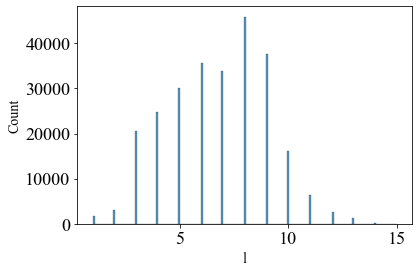

In [145]:
cent = '17'
path_df = lenght_all_pairs_shortest_path(cent_nets[cent])
cent_diameter = path_df['l'].max()
print('cent_diameter:', cent_diameter, 'from', len(path_df), 'all-pairs-paths')
sns.histplot(path_df['l'])

max tree diameter: 8


<AxesSubplot:xlabel='tree height from diamter directed', ylabel='Count'>

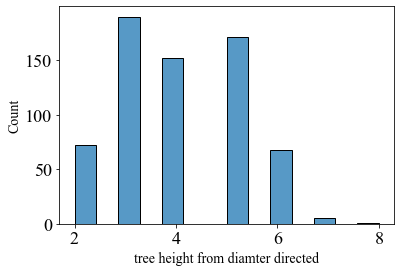

In [146]:
print('max tree diameter:', tree_cent_df[tree_cent_df['cent'] == cent]['tree height from diamter directed'].max())
sns.histplot(tree_cent_df[tree_cent_df['cent'] == cent]['tree height from diamter directed'])

In [147]:
path_df[path_df['l'] == cent_diameter].drop_duplicates('p')

,l,p
134581,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O graf', 'PR von', 'N/O reich', 'PR wegen', 'N/O auffhebung', 'N/O belagerung', 'PR vor', 'N/O ritter', 'AJ/O bast']"
134582,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'AD wie', 'N/S herz', 'N/S clara', 'AJ/S heilig']"
134583,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'AD wie', 'N/S herz', 'N/S lehrer', 'AJ/S reich']"
134584,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'AD wie', 'N/S herz', 'N/S lehrer', 'N/S augustini']"
134585,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'AD wie', 'N/S herz', 'N/S mann', 'AJ/S gottselig']"
134586,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'AD wie', 'N/S herz', 'N/S mann', 'N/S francisco']"
134587,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS finden', 'N/O meile', 'AJ/O halbe']"
134588,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS achten', 'AD hoch', 'AD sehr']"
134589,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS schicken', 'CJ als', 'N/S gesandter']"
134590,15,"['N/S gut', 'N/S viel', 'N/S nicht', 'PR ane', 'N/O munition', 'PR mit', 'N/O zeit', 'AJ/O viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS verzücken', 'N/O prediger', 'AJ/O tarsenisch']"


# Analysis of Hirearchy

- using Graph Hierarchy https://github.com/shuaib7860/GraphHierarchy

## Nodal Measures: Hirearchichal Levels
- Hierarchical levels is a generalisation of the notion of trophic levels and describes each vertex’s rank with respect to
“enegry” or “information” flow.
- Influence centrality is a measure of a vertex’s ability to influence the long term state of the graph.
- The democracy coefficient measures the feedback that is present in the graph.
- The hierarchical incoherence parameter is a straightforward generalisation of trophic incoherence.

In [58]:
h_measures_df = []

for cent, G in tqdm(cent_nets.items()):
    
    tmp_df = pd.concat([
            
            pd.Series(
                list(G.nodes), 
                name='node'
            ),
        
            pd.Series(
                gh.hierarchical_levels(G, weight='frequency'), 
                name='hierarchical_levels'
            )
        ], axis=1
    )
    
    tmp_df['cent'] = cent
    
    f_hierarchical_levels, f_influence_centrality, f_hierarchical_diff_adj_sparse, f_democracy_coefficient, f_hierarchical_incoherence = gh.forward_hierarchical_metrics(G, weight='frequency')
    
    b_hierarchical_levels, b_influence_centrality, b_hierarchical_diff_adj_sparse, b_democracy_coefficient, b_hierarchical_incoherence = gh.backward_hierarchical_metrics(G, weight='frequency')
    
    tmp_df['f_hierarchical_levels'] = f_hierarchical_levels
    tmp_df['b_hierarchical_levels'] = b_hierarchical_levels
    
    tmp_df['f_influence_centrality'] = f_influence_centrality
    tmp_df['b_influence_centrality'] = b_influence_centrality
    
    tmp_df['f_democracy_coefficient'] = f_democracy_coefficient
    tmp_df['b_democracy_coefficient'] = b_democracy_coefficient
    
    tmp_df['f_hierarchical_incoherence'] = f_hierarchical_incoherence
    tmp_df['b_hierarchical_incoherence'] = b_hierarchical_incoherence
    
    path_df = lenght_all_pairs_shortest_path(G)
    tmp_df['diameter directed'] = path_df['l'].max()

    
    tmp_df['diameter undirected'] = None
    if False:
        G_u = G.to_undirected()
        Gcc = sorted(nx.connected_components(G_u), key=len, reverse=True)
        giant = G_u.subgraph(Gcc[0])
        tmp_df['diameter undirected'] = nx.diameter(giant)
        pass
    
    
    tmp_df = pd.merge(
        pd.DataFrame(G.out_degree(), columns=['node', 'out_degree']),
        tmp_df,
        on='node', how='right'
    )
    
    tmp_df = pd.merge(
        pd.DataFrame(G.in_degree(), columns=['node', 'in_degree']),
        tmp_df,
        on='node', how='right'
    )
    
    
    h_measures_df.append(tmp_df)
    
    del path_df
#     break
    pass
    
h_measures_df = pd.concat(h_measures_df).reset_index(drop=True)
len(h_measures_df)

# cent_to_num = {
#     '11': 11.0, '12': 12.0, '13': 13.0, 'E14': 14.1, 'L14': 14.2, '15': 15.0, '16': 16.0, '17': 17.0
# }

h_measures_df['cent_num'] = h_measures_df['cent'].map(centuries)

h_measures_df.insert(1, 'node func', h_measures_df['node'].apply(lambda x: x.split(' ')[0]))
h_measures_df.insert(4, 'degree', h_measures_df['in_degree'] + h_measures_df['out_degree'])

h_measures_df

100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.48s/it]


,node,node func,in_degree,out_degree,degree,hierarchical_levels,cent,f_hierarchical_levels,b_hierarchical_levels,f_influence_centrality,b_influence_centrality,f_democracy_coefficient,b_democracy_coefficient,f_hierarchical_incoherence,b_hierarchical_incoherence,diameter directed,diameter undirected,cent_num
0,AX werden,AX,0,181,181,-1.500765,11,-1.800434,1.201095,1.000000e+00,-2.634692e-11,1.111531e-07,2.631389e-09,0.312015,0.592194,7,None,11.0
1,PP/S er,PP/S,11,1,12,0.029760,11,-0.710904,-0.770425,-1.873787e-09,4.282613e-06,1.111531e-07,2.631389e-09,0.312015,0.592194,7,None,11.0
2,AX sin,AX,0,10,10,-1.759693,11,-2.177333,1.342053,1.000000e+00,-8.436245e-09,1.111531e-07,2.631389e-09,0.312015,0.592194,7,None,11.0
3,PCPS werden,PCPS,1,15,16,-1.071558,11,-1.177333,0.965783,-8.003956e-08,-1.556790e-08,1.111531e-07,2.631389e-09,0.312015,0.592194,7,None,11.0
4,V werden,V,0,71,71,-1.046527,11,-1.313960,0.779094,1.000000e+00,-6.483205e-10,1.111531e-07,2.631389e-09,0.312015,0.592194,7,None,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6830,N /s nacht,N,1,0,1,-0.231417,17,-0.472614,-0.009781,-4.674039e-08,1.000000e+00,2.539334e-04,-8.130752e-08,0.410124,0.650922,15,None,17.0
6831,N/S ein,N/S,1,0,1,-0.231417,17,-0.472614,-0.009781,-4.674039e-08,1.000000e+00,2.539334e-04,-8.130752e-08,0.410124,0.650922,15,None,17.0
6832,N/S gleich,N/S,1,0,1,-0.231417,17,-0.472614,-0.009781,-4.674039e-08,1.000000e+00,2.539334e-04,-8.130752e-08,0.410124,0.650922,15,None,17.0
6833,PP/S derselb,PP/S,1,0,1,-0.231417,17,-0.472614,-0.009781,-4.674039e-08,1.000000e+00,2.539334e-04,-8.130752e-08,0.410124,0.650922,15,None,17.0


In [59]:
'''
CORRELATION TEST
https://realpython.com/numpy-scipy-pandas-correlation-python/
'''

col_1 = ['', 'in_degree', 'out_degree', 'degree'][1]
col_2 = ['',
    'f_hierarchical_levels', 'b_hierarchical_levels', 'hierarchical_levels',
    'f_influence_centrality', 'b_influence_centrality'
][1]

print('Spearmanr Correlation between "{}" and "{}"'.format(col_1, col_2))

for cent_num in h_measures_df['cent_num'].unique():
    df = h_measures_df[h_measures_df['cent_num'] == cent_num]

    print('cent: {} | {}'.format(cent_num, stats.spearmanr(df[col_1], df[col_2])))
# diameter

print('cent: ALL | {}'.format(stats.spearmanr(h_measures_df[col_1], h_measures_df[col_2])))

Spearmanr Correlation between "in_degree" and "f_hierarchical_levels"
cent: 11.0 | SpearmanrResult(correlation=0.22236332173474654, pvalue=2.1690453589817776e-06)
cent: 12.0 | SpearmanrResult(correlation=0.19244905396495807, pvalue=2.3188610730354576e-05)
cent: 13.0 | SpearmanrResult(correlation=0.2438270837948431, pvalue=5.9426427261126805e-12)
cent: 14.1 | SpearmanrResult(correlation=0.1860293928642405, pvalue=3.2156827554006384e-07)
cent: 14.2 | SpearmanrResult(correlation=0.27359272314337607, pvalue=1.69476434684313e-14)
cent: 15.0 | SpearmanrResult(correlation=0.25337479778635524, pvalue=3.241433171909951e-12)
cent: 16.0 | SpearmanrResult(correlation=0.12492036660263267, pvalue=1.4979980383922256e-05)
cent: 17.0 | SpearmanrResult(correlation=0.12439935210086582, pvalue=2.5236181984714073e-07)
cent: ALL | SpearmanrResult(correlation=0.16614171373251418, pvalue=1.6963629885721267e-43)


In [60]:
'''
ANOTHER VALIDATION
TODO NOTE: add a column to check number of times function is used
'''

func_frac_df = h_measures_df.groupby(['node func', 'cent']).agg(node_count_func = ('node func', np.size))

func_frac_df['node frac'] = func_frac_df['node_count_func'] / len(h_measures_df)

# dunc_frac_df.to_excel('node_func_possible_more_bugs.xlsx')

func_frac_df.sort_values(by='node frac', ascending=False)

node_count_func  node frac
node func cent                            
N         16    546              0.079883 
N/O       17    416              0.060863 
PCPS      17    335              0.049012 
N         15    298              0.043599 
N/S       17    284              0.041551 
N         14L   272              0.039795 
PCPS      16    215              0.031456 
          14L   188              0.027505 
          13    174              0.025457 
N/S       13    173              0.025311 
AJ        16    172              0.025165 
PCPS      14E   170              0.024872 
N/S       14E   167              0.024433 
PCPS      15    161              0.023555 
AD        17    157              0.022970 
N/O       13    153              0.022385 
AJ/O      17    144              0.021068 
AJ        14L   137              0.020044 
PCPS      12    135              0.019751 
AJ/S      14E   130              0.019020 
PCPS      11    129              0.018873 
AJ        15    127              0.018581 
AJ/S      17    127              0.018581 
IV        17    126              0.018435 
N/O       14E   110              0.016094 
AD        16    110              0.016094 
N/S       12    106              0.015508 
AJ/S      13    94               0.013753 
IV        16    83               0.012143 
N/S       11    82               0.011997 
N/O       12    79               0.011558 
          11    75               0.010973 
AD        14L   72               0.010534 
          13    62               0.009071 
          15    61               0.008925 
AJ/S      11    54               0.007901 
AD        14E   52               0.007608 
AJ/S      12    42               0.006145 
AD        12    42               0.006145 
AJ/O      13    41               0.005999 
IV        15    37               0.005413 
AD        11    32               0.004682 
PR        17    31               0.004535 
AJ/O      14E   28               0.004097 
IV        14L   24               0.003511 
AJ/O      11    24               0.003511 
PR        16    19               0.002780 
PP        16    19               0.002780 
AJ/O      12    18               0.002634 
PR        14L   18               0.002634 
PCPR      13    18               0.002634 
PR        15    17               0.002487 
          13    16               0.002341 
PCPR      14E   15               0.002195 
PR        14E   14               0.002048 
IV        14E   13               0.001902 
PCPR      14L   13               0.001902 
PR        11    12               0.001756 
PP/S      17    11               0.001609 
          14E   11               0.001609 
PP        14L   11               0.001609 
PP/S      13    10               0.001463 
PR        12    10               0.001463 
PP        15    10               0.001463 
PP/O      17    10               0.001463 
PP/S      11    8                0.001170 
AR/S      17    7                0.001024 
DM/S      13    7                0.001024 
PP        17    7                0.001024 
PP/S      12    6                0.000878 
DM/S      17    6                0.000878 
MV        17    6                0.000878 
AR/O      17    6                0.000878 
RP/S      17    6                0.000878 
CJ        17    6                0.000878 
AR        16    6                0.000878 
MV        16    5                0.000732 
          15    5                0.000732 
          14E   5                0.000732 
          13    5                0.000732 
PP/O      14E   5                0.000732 
V         14L   5                0.000732 
PP/O      11    5                0.000732 
          12    5                0.000732 
          13    5                0.000732 
DM/S      12    5                0.000732 
          14E   5                0.000732 
IV        12    5                0.000732 
DM/O      17    4                0.000585 
          14E   4                0.000585 
MV        14L   4                0.000585 
DM        16    4

In [61]:
h_measures_df

# f_democracy_coefficient

h_measures_df[h_measures_df['f_influence_centrality'] > 0.1][['node', 'cent', 'f_influence_centrality', 'f_hierarchical_levels']]

,node,cent,f_influence_centrality,f_hierarchical_levels
0,AX werden,11,1.0,-1.800434
2,AX sin,11,1.0,-2.177333
4,V werden,11,1.0,-1.313960
7,MV mügen,11,1.0,-2.760714
10,MV wellen,11,1.0,-2.605086
12,MV sollen,11,1.0,-1.507236
240,MV müssen,11,1.0,-0.352525
444,V wesen,11,1.0,-0.045524
445,AX werden,12,1.0,-1.701501
447,MV sollen,12,1.0,-2.366651


In [62]:
if False:
    h_measures_df.to_excel(path_dataset_dir + 'hierarchical_metrics_german.xlsx')
    
if False:
    h_measures_df = pd.read_excel(path_dataset_dir + 'hierarchical_metrics_german.xlsx')

In [63]:
print(h_measures_df['cent'].value_counts())
h_measures_df.columns

17     1707
16     1194
13     775 
14L    759 
14E    744 
15     734 
12     477 
11     445 
Name: cent, dtype: int64


Index(['node', 'node func', 'in_degree', 'out_degree', 'degree',
       'hierarchical_levels', 'cent', 'f_hierarchical_levels',
       'b_hierarchical_levels', 'f_influence_centrality',
       'b_influence_centrality', 'f_democracy_coefficient',
       'b_democracy_coefficient', 'f_hierarchical_incoherence',
       'b_hierarchical_incoherence', 'diameter directed',
       'diameter undirected', 'cent_num'],
      dtype='object')

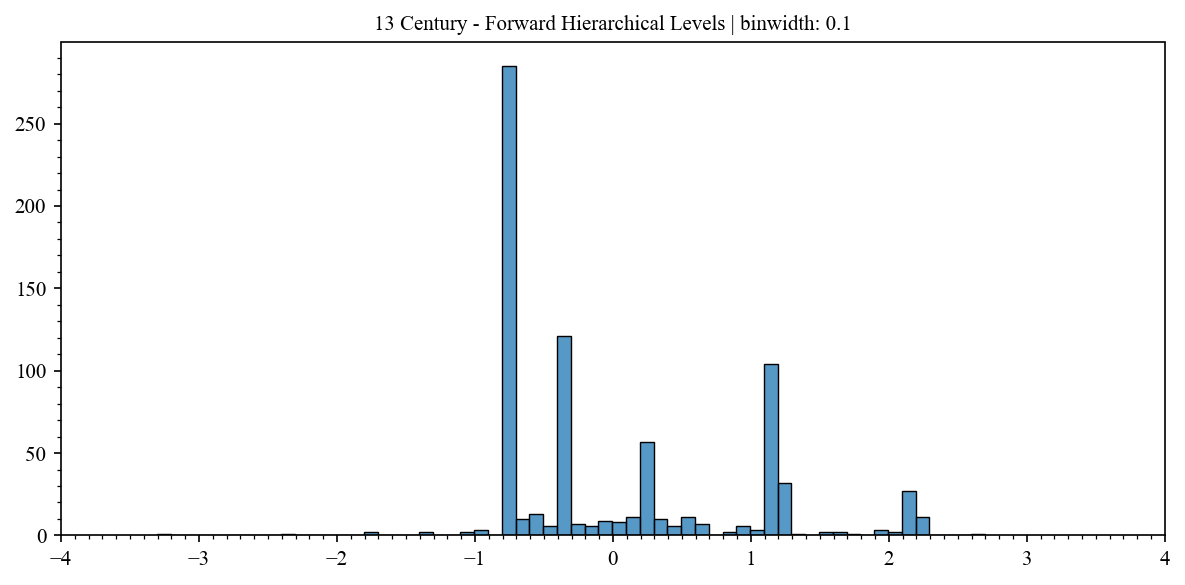

In [64]:
def plot_hirearchy_measure_single_cent(h_measures_df, cent, binwidth, figsize):
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 12

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    matplotlib.rcParams['font.serif'] = "Times New Roman"
    matplotlib.rcParams['font.family'] = "serif"
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

    plt.figure(figsize=figsize, dpi=150)

    h_levels_tmp = h_measures_df[h_measures_df['cent'] == cent]

    g = sns.histplot(
        data=h_levels_tmp, x='f_hierarchical_levels', binwidth=binwidth
    )
    
    g.set_title('{} Century - Forward Hierarchical Levels | binwidth: {}'.format(cent, binwidth), loc='center')
    g.set(xlabel='', ylabel='', xlim=(-4, 4))
    
    g.xaxis.set_major_locator(plt.MultipleLocator(1))
    g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    
    
    g.yaxis.set_major_locator(plt.MultipleLocator(50))
    g.yaxis.set_minor_locator(plt.MultipleLocator(10))

    plt.tight_layout()

    pass

plot_hirearchy_measure_single_cent(h_measures_df=h_measures_df, binwidth=0.1, cent='13', figsize=(8,4))

8it [00:01,  6.37it/s]


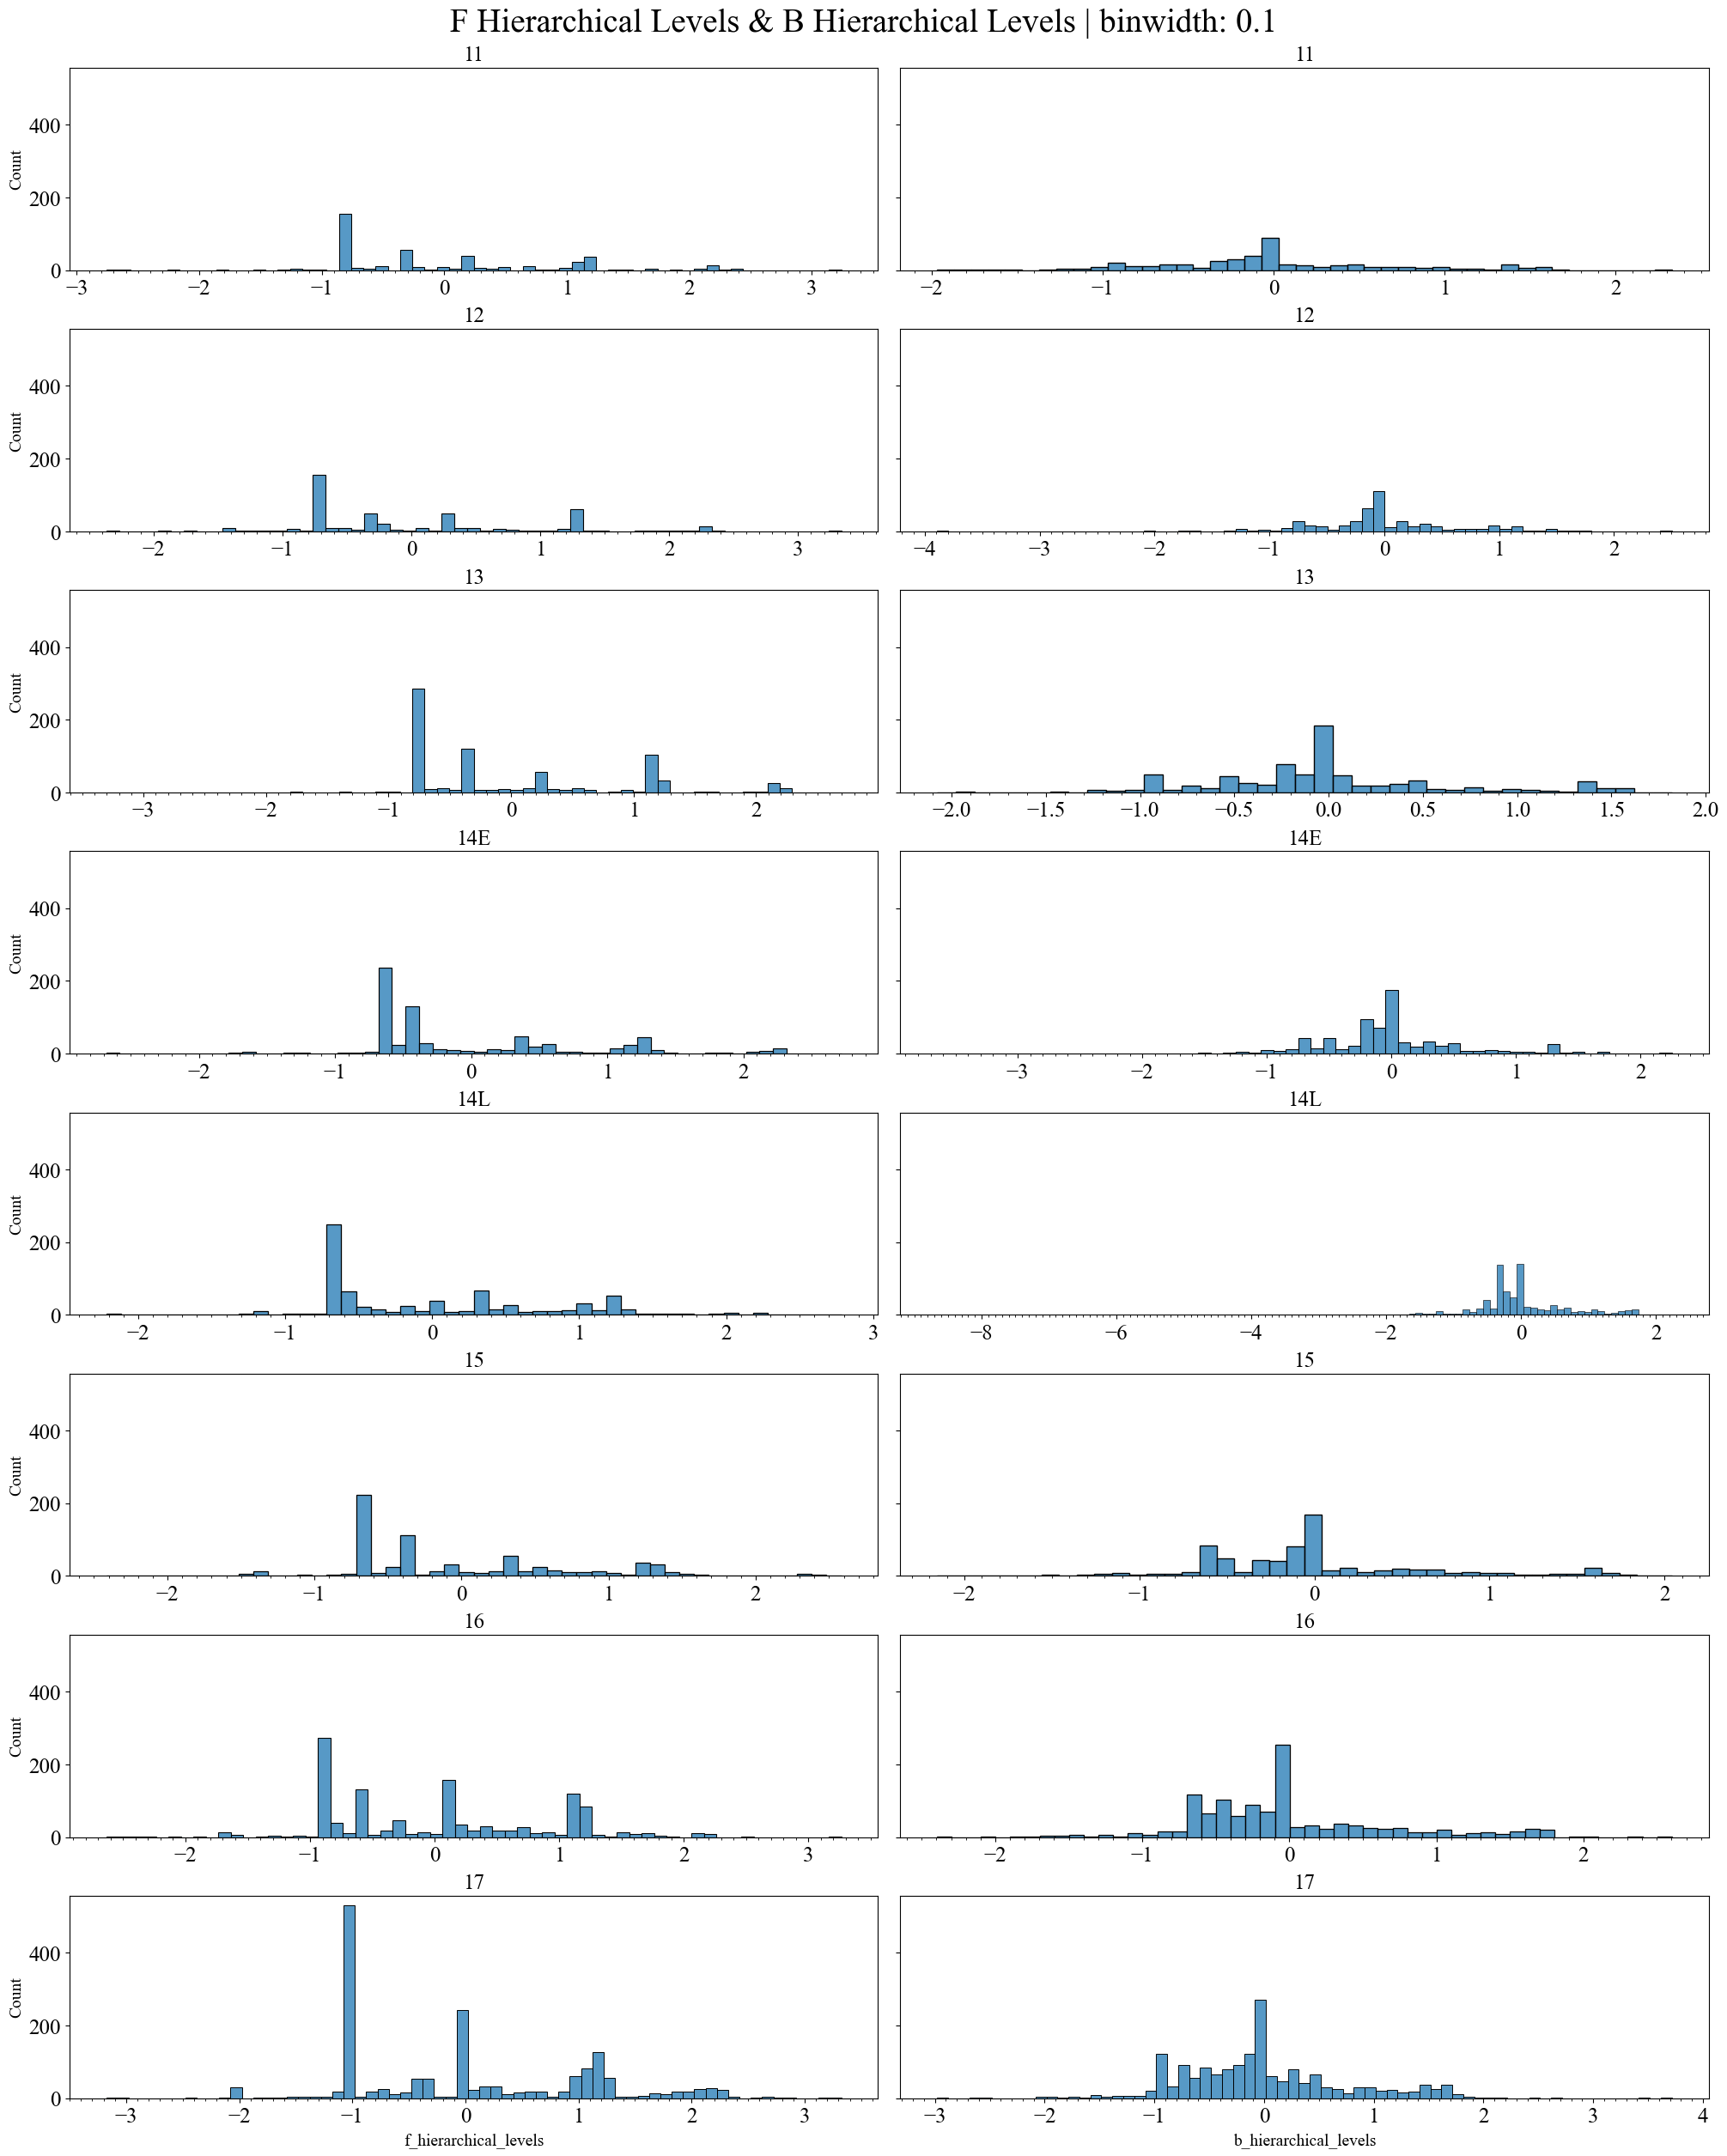

In [65]:
def plot_hirearchy_measure(h_measures_df, binwidth, func_names, ylim_dict=None):
    SMALL_SIZE = 18
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 28

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    matplotlib.rcParams['font.serif'] = "Times New Roman"
    matplotlib.rcParams['font.family'] = "serif"
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

    fig, axes = plt.subplots(nrows=len(cent_nets.keys()), ncols=2, constrained_layout=True,
        sharex=False, sharey=True, dpi=100, figsize=(20, 25))

    fig.suptitle('{} | binwidth: {}'.format(
        ' & '.join(func_names).replace('_', ' ').title(), binwidth
    ))
    
    cents = list(cent_nets.keys())
    
    for row, cent in tqdm(enumerate(cents)):

        h_levels_tmp = h_measures_df[h_measures_df['cent'] == cent]

        g = sns.histplot(
            data=h_levels_tmp, x=func_names[0],
            ax=axes[row, 0], binwidth=binwidth
        )
        
        g.set_title('{}'.format(cent), loc='center')
        
        g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
        
        # write xlabel only for last plot in column
        if cent != cents[-1]:
            g.set(xlabel='')
        
        if False:
            g.set(ylim=(0, ylim_dict[binwidth]) #, xlim=(0, 1), 
                  #xlabel=covars_latex_dicts[x_col], ylabel=covars_latex_dicts[y_col]
            )
            pass
#         g.xaxis.set_major_locator(plt.MultipleLocator(1))
#         g.yaxis.set_major_locator(plt.MultipleLocator(100))
#         print(ylim_dict[binwidth])
        '''-------------------------------'''
        g = sns.histplot(
            data=h_levels_tmp, x= func_names[1],
            ax=axes[row, 1], binwidth=binwidth
        )
        g.set_title('{}'.format(cent), loc='center')
        
        g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
        
        # write xlabel only for last plot in column
        if cent != cents[-1]:
            g.set(xlabel='')
        
        if False:
            g.set(ylim=(0, ylim_dict[binwidth]) #, xlim=(0, 1), 
                  #xlabel=covars_latex_dicts[x_col], ylabel=covars_latex_dicts[y_col]
            )
            pass
#         g.xaxis.set_major_locator(plt.MultipleLocator(1))
#         g.yaxis.set_major_locator(plt.MultipleLocator(100))

        pass
    pass

binwidth = [0.1, None][0]
# func_name = ['hierarchical_levels', 'forward_hierarchical_levels'][1]
func_names = [
    ('hierarchical_levels', 'f_hierarchical_levels'),
    ('hierarchical_levels', 'b_hierarchical_levels'),
    ('f_hierarchical_levels', 'b_hierarchical_levels'),
    
#     ('f_influence_centrality', 'f_hierarchical_levels')
][-1]
# ylim_dicts={
#     ('forward_hierarchical_levels weighted', 'backward_hierarchical_levels weighted'): {
#         0.25:300, 0.5: 250, 0.75: 300, 1.0: 350, None: 400},
#     ('hierarchical_levels weighted', 'forward_hierarchical_levels weighted'): {None: 400},
#     ('hierarchical_levels weighted', 'backward_hierarchical_levels weighted'): {None: 400},
# }

plot_hirearchy_measure(h_measures_df=h_measures_df, 
                       binwidth=binwidth, 
#                        ylim_dict=ylim_dicts[func_names], 
                       func_names=func_names)

In [66]:
h_measures_df.describe()

,in_degree,out_degree,degree,hierarchical_levels,f_hierarchical_levels,b_hierarchical_levels,f_influence_centrality,b_influence_centrality,f_democracy_coefficient,b_democracy_coefficient,f_hierarchical_incoherence,b_hierarchical_incoherence,diameter directed,cent_num
count,6835.000000,6835.000000,6835.000000,6.835000e+03,6.835000e+03,6.835000e+03,6.835000e+03,6.835000e+03,6.835000e+03,6.835000e+03,6835.000000,6835.000000,6835.000000,6835.000000
mean,1.882224,1.882224,3.764448,1.700728e-15,3.462791e-15,6.757173e-17,1.199737e-02,4.421357e-01,6.352220e-05,8.806481e-05,0.416104,0.617038,11.229846,14.790812
std,5.597699,12.818184,14.360664,7.081931e-01,9.303308e-01,6.835009e-01,1.088801e-01,4.966772e-01,1.098670e-04,2.496222e-04,0.086226,0.058289,4.131507,1.847425
min,0.000000,0.000000,1.000000,-2.534865e+00,-3.305529e+00,-8.665899e+00,-3.563290e-04,-1.028385e-03,-1.390377e-07,-4.133028e-07,0.284485,0.504141,6.000000,11.000000
25%,1.000000,0.000000,1.000000,-4.602398e-01,-7.014983e-01,-3.984532e-01,-1.133302e-06,-7.149948e-07,7.468562e-08,-3.319631e-07,0.335217,0.573549,9.000000,14.100000
50%,1.000000,1.000000,2.000000,-1.387327e-01,-3.228319e-01,-3.535096e-02,3.287958e-08,2.478616e-05,3.206034e-07,-8.130752e-08,0.410124,0.650922,9.000000,15.000000
75%,1.000000,1.000000,3.000000,5.144729e-01,6.869202e-01,2.728432e-01,2.258173e-06,1.000000e+00,3.641501e-07,2.631389e-09,0.501542,0.663706,15.000000,16.000000
max,185.000000,511.000000,511.000000,5.680742e+00,3.321540e+00,3.651819e+00,1.000000e+00,1.000001e+00,2.539334e-04,7.942837e-04,0.538600,0.673499,17.000000,17.000000


In [ ]:
# cen = '11'
# plt.figure(figsize=(15,8))
# sns.histplot(data=h_measures_df[h_measures_df['cent'] == cent], x='f_influence_centrality')

In [ ]:
h_measures_df.columns

## FHL

In [ ]:
h_measures_df['cent_FHL'] = h_measures_df.apply(lambda r: (r['cent'], round(r['f_hierarchical_levels'], 3)), axis=1)

In [ ]:
nodes_FHL_df = (
    h_measures_df
    .groupby('node')
    .agg(
        FHL_avg=('f_hierarchical_levels', np.mean), 
        FHL_std=('f_hierarchical_levels', np.std), 
        count_cent=('cent', np.size),
        cent_FHL=('cent_FHL', lambda x: list(x))
    )
    .sort_values(by='FHL_std', ascending=False)
)

if True:
    nodes_FHL_df.to_excel('nodes_FHL_df.xlsx')
    
nodes_FHL_df[nodes_FHL_df.index == 'N geist']

In [ ]:
print('Number of nodes exists only single century (std=0):', sum(nodes_FHL_df['FHL_std'].isnull()), 'from', len(nodes_FHL_df))

for r in reversed(np.arange(0.5, 2.1, 0.25)):

    print('Number of Nodes with std >= {}: {} from {} | Exists in {} centuries'.format(
        r,
        sum(nodes_FHL_df['FHL_std'] >= r),
        sum(~nodes_FHL_df['FHL_std'].isnull()),
        round(nodes_FHL_df[nodes_FHL_df['FHL_std'] >= r]['count_cent'].mean(), 2)
    ))

## Influence Centrality

In [ ]:
'''Forward'''
heads_f_influence_centrality = h_measures_df[h_measures_df['f_influence_centrality'] > 0.1].groupby(['node', 'cent']).agg(count = ('cent', np.size))

head_f_influence = (
    heads_f_influence_centrality
    .reset_index()
    .pivot(index=['node'], columns='cent', values='count')
    .fillna(0)
)

head_f_influence['sum'] = head_f_influence.sum(axis=1)

head_f_influence = head_f_influence.sort_values(by=['sum'], ascending=False)

if True:
    head_f_influence.to_excel(path_dataset_dir + 'influence_cent_forward_high_0.1.xlsx')

head_f_influence

In [ ]:
'''Backward'''
heads_f_influence_centrality = h_measures_df[h_measures_df['b_influence_centrality'] > 0.1].groupby(['node', 'cent']).agg(count = ('cent', np.size))

head_f_influence = (
    heads_f_influence_centrality
    .reset_index()
    .pivot(index=['node'], columns='cent', values='count')
    .fillna(0)
)

head_f_influence['sum'] = head_f_influence.sum(axis=1)

head_f_influence = head_f_influence.sort_values(by=['sum'], ascending=False)

if True:
    head_f_influence.to_excel(path_dataset_dir + 'influence_cent_backward_high_0.1.xlsx')

head_f_influence

In [ ]:
[n for n in nodes_all_cent if 'werden' in n]

In [ ]:
h_measures_df

In [ ]:
plt.figure(figsize=(15,8))

ax = sns.scatterplot(data=h_measures_df, x='f_influence_centrality', y='b_influence_centrality', 
                     hue='cent_num', alpha=0.2, linewidth=0, legend='full')

ax.set(xscale='log', yscale='log')

# h_measures_df['f_influence_centrality']

In [ ]:
measure = ['f_influence_centrality'][0]

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=h_measures_df, y=measure, x='cent')
ax.set(yscale="log")
ax.set_title(measure)

In [ ]:
h_measures_df

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='f_hierarchical_levels', hue='cent_num', binwidth=0.1)

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='b_hierarchical_levels', hue='cent_num', binwidth=0.1)

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='hierarchical_levels', hue='cent_num', binwidth=0.1)

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_levels_df, x='hierarchical_levels NOT weighted', hue='cent')

In [ ]:
# plt.figure(figsize=(15,8))
# sns.histplot(
#     data=h_levels_df[h_levels_df['cent'].isin(['11', '17'])], 
#     x='hierarchical_levels', hue='cent')

In [ ]:
# sns.histplot(data=h_levels_df, x='hierarchical_levels', hue='cent')

fig = px.histogram(h_levels_df, x="hierarchical_levels weighted", color="cent", barmode="overlay")

fig.update_xaxes(range=[-9, +12], autorange=False)
fig.update_yaxes(range=[0, 110], autorange=False)

# fig.show()

pio.show(fig, renderer='browser', validate=True)
# fig.write_html(file_save)

## Global Measures: Democracy Coeff and Hierarchical Incoherence

In [ ]:
# %config Completer.use_jedi = False
# G.nodes
h_measures_df[h_measures_df['node'] == 'IV werden']

In [ ]:
G.edges[('AX werden', 'IV erben')]
gh.node_backward_influence_centrality(G, 'IV werden', weight='frequency')

In [ ]:
dem_forw_df = []

for cent, G in tqdm(cent_nets.items()):
    FHD_adj, FHD_mean, FHD_std = gh.forward_hierarchical_incoherence(G, weight='frequency')
    
#     b_hierarchical_level_vector, b_influence_centrality_vector, b_hierarchical_diff_adj_sparse, b_democracy_coefficient, b_hierarchical_incoherence = gh.backward_hierarchical_metrics(G, weight='frequency')
    
    hierarchical_level_vector, influence_centrality_vector, hierarchical_diff_adj_sparse, democracy_coefficient, hierarchical_incoherence = gh.forward_hierarchical_metrics(G, weight='frequency')
    
    dem_forw_df.append(
        {
            'cent': cent,
            'forward_hierarchical_incoherence avg': FHD_mean,
            'forward_hierarchical_incoherence std': FHD_std,
            'forward_democracy_coefficient': gh.forward_democracy_coefficient(
                G, weight='frequency'),
            'backward_democracy_coefficient': gh.backward_democracy_coefficient(
                G, weight='frequency'),
            'democracy_coefficient': democracy_coefficient,
            'hierarchical_incoherence': hierarchical_incoherence
        }
    )
    
dem_forw_df = pd.DataFrame(dem_forw_df)
dem_forw_df['cent_num'] = dem_forw_df['cent'].map(centuries)
dem_forw_df

In [ ]:
plt.figure(figsize=(8, 6), dpi=100)
sns.scatterplot(data=dem_forw_df, x="hierarchical_incoherence", y="democracy_coefficient", hue='cent',
               s=100, legend='full')

In [ ]:
dem_forw_df

In [ ]:
ax = sns.barplot(x="cent", y="forward_hierarchical_incoherence std", data=dem_forw_df)

In [ ]:
'UNWEIGHTED'

In [ ]:
ax = sns.barplot(x="cent", y="forward_democracy_coefficient", data=dem_forw_df)

In [ ]:
dem_forw_df

In [ ]:
ax = sns.barplot(x="cent", y="backward_democracy_coefficient", data=dem_forw_df)

## Challenges

- https://stackoverflow.com/questions/57458789/get-bin-width-used-for-seaborn-plot
- ITS SO GOOD: https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
- https://stackoverflow.com/questions/56605113/how-to-set-x-axis-ticklabels-in-a-seaborn-plot

# [OLD] yFiles Hierarchical Layout

In [ ]:
path_yfiles_layout = 'D:/GoogleDrive/Research/Linguistic project/German/data/Hierarchical Layout yfiles/'

path_networks = OrderedDict()

path_networks['11'] = path_yfiles_layout + "/Cent11.cyjs" 
path_networks['12'] = path_yfiles_layout + "/Cent12.cyjs" 
path_networks['13'] = path_yfiles_layout + "/Cent13.cyjs" 
path_networks['14E'] = path_yfiles_layout + "/Cent14E.cyjs" 

path_networks['14L'] = path_yfiles_layout + "/Cent14L.cyjs" 
path_networks['15'] = path_yfiles_layout + "/Cent15.cyjs" 
path_networks['16'] = path_yfiles_layout + "/Cent16.cyjs" 
path_networks['17'] = path_yfiles_layout + "/Cent17.cyjs" 

In [ ]:
layouts = OrderedDict()
cen_layers = {}

for cent, path_layout in path_networks.items():
    f = open(path_layout, "r", encoding='utf-8')
    layouts[cent] = json.loads(f.read())
    
    cen_layers[cent] = []
    
    for node in layouts[cent]['elements']['nodes']:
        
        cen_layers[cent].append({
            'name': node['data']['name'],
            'x': node['position']['x'],
            'y': node['position']['y'],
            'y_round': round(node['position']['y'])
        })
        pass
    
    cen_layers[cent] = pd.DataFrame(cen_layers[cent])
    """Now convert unique y value to sequential layer number"""
    map_y_val_to_layer_num = {
        y: l + 1 for l, y in enumerate(sorted(set(cen_layers[cent]['y_round'])))
    }
    
    cen_layers[cent]['layer'] = cen_layers[cent]['y_round'].map(map_y_val_to_layer_num)
    
    cen_layers[cent] = cen_layers[cent].sort_values('layer').reset_index(drop=True)
#     break
    pass
# del layers
map_y_val_to_layer_num
cen_layers['17'].columns
# cen_layers.keys()

In [ ]:
cen_layer_count = []
for cen, cen_layer in cen_layers.items():
    cen_layer_count.append({
        'cent': cen,
        'num layers': cen_layer['layer'].max()
    })
    pass

cen_layer_count = pd.DataFrame(cen_layer_count)

cen_layers['cen_layer_count'] = cen_layer_count

cen_layers['cen_layer_count']

In [ ]:
%matplotlib inline

ax=sns.barplot(x="cent", y="num layers", data=cen_layer_count)
ax.set(ylim=(0, 30), title='Number of Layers in Each Century')

In [ ]:
save_xls(dfs_dict=cen_layers, 
         xls_path=path_yfiles_layout + '/all_cent_layers_yfiles.xlsx', 
         open=True)

# [OLD] Graph Hierarchy 
- How to draw netwrokx graph https://faculty.math.illinois.edu/~hirani/cbmg/graphs.html
- Add x-y axis when drawing with NetworkX https://stackoverflow.com/questions/56994061/how-to-make-x-and-y-axes-appear-when-using-networkx-and-matplotlib
- A cool toturial for visualization https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial

In [ ]:

graph = nx.gnr_graph(20, 0.4)
nx.draw_networkx(graph)

In [ ]:
l = list(zip(
    graph.nodes(),
#     gh.forward_hierarchical_levels(graph)
    gh.hierarchical_levels(graph)
))

l.sort(key=lambda x: x[1])
l

In [ ]:
level_dict = {}
level_num = 0
prev_layer_level = None
offset = 0

for node, level in l:
    if prev_layer_level is not None:
        offset = 1 - (level - prev_layer_level)
    
#     print('l: ', level, 'o: ', offset)
    
    if level not in level_dict:
        level_dict[level] = []
        level_num += 1
        prev_layer_level = level
        pass
    
    level_dict[level].append(node)
#     print(level + (np.sign(level) * 1))
    graph.nodes[node]['pos'] = (
        (len(level_dict[level]) * 2) + random.uniform(-1, 1),
        level 
    )
    pass

# plt.figure(3,figsize=(12,12)) 

fig, ax = plt.subplots()
fig.set_dpi(150)
fig.set_size_inches(10,10)
pos=nx.get_node_attributes(graph,'pos')

plt.figure(3,figsize=(12,12)) 

nx.draw_networkx(graph, pos, ax=ax)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

In [ ]:
print('levels: ', len(level_dict))

In [ ]:
node_l_dict = dict(l)
node_l_dict[0] - node_l_dict[1]

In [ ]:
gh.forward_hierarchical_differences(graph)


In [ ]:
(hierarchical_differences_sparse, 
 hierarchical_differences_mean, 
 hierarchical_differences_std) = gh.forward_hierarchical_incoherence(graph)

"""The standard deviation of the distribution is known as the forward hierarchical incoherence and is an important metric which gives a measure of a network's organisation and structure."""
print('mean:', hierarchical_differences_mean, 'std:' , hierarchical_differences_std)

In [ ]:
gh.forward_democracy_coefficient(graph)

In [ ]:
for node in graph.nodes:
    print(node, gh.node_forward_influence_centrality(graph, node))

In [ ]:
gh.forward_influence_centrality(graph)


In [ ]:
gh.hierarchical_levels(graph)
